In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import glob

In [2]:
train_raw = None
for filename in glob.glob('train*.csv'):
    _data = pd.read_csv(filename, sep=',', index_col='id')
    if train_raw is None:
        train_raw = _data
    else:
        train_raw = pd.concat([train_raw, _data])

In [3]:
train_raw.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
id,,,,,,,,,,
0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [4]:
train_df = train_raw.copy()

In [5]:
from sklearn.preprocessing import LabelEncoder

species = train_raw['Species']
island = train_raw['Island']
train_mass = train_raw['Body Mass (g)']

le = LabelEncoder().fit(species)
isl_le = LabelEncoder().fit(island)

train_df['Species'] = le.transform(species)
train_df['Island'] = isl_le.transform(island)

In [6]:
train_df.replace('Yes', 1, inplace=True)
train_df.replace('No', 0, inplace=True)

In [7]:
train_df.replace('MALE', 0, inplace=True)
train_df.replace('FEMALE', 1, inplace=True)

In [8]:
def normalize(df, tag_min, tag_max):
    ndf = df.copy()
    for c in df.columns:
        if tag_min[c] == tag_max[c]:
            ndf[c] = df[c] - tag_min[c]
        else:
            ndf[c] = (df[c] - tag_min[c]) / (tag_max[c] - tag_min[c])
    return ndf


def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [9]:
train_df = train_df.drop(['Body Mass (g)'], axis=1)

<AxesSubplot:>

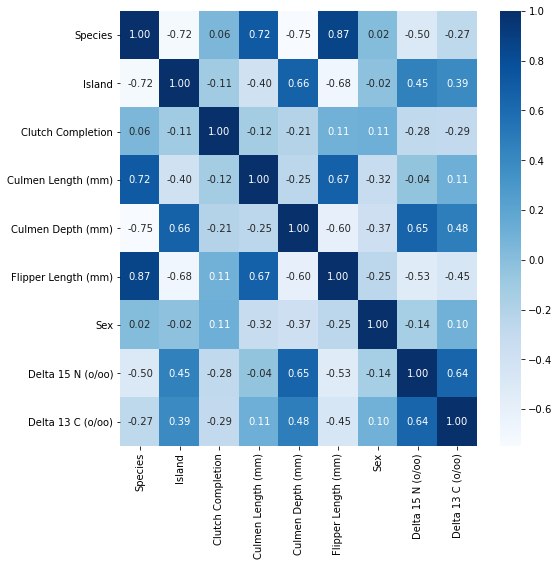

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr(), fmt='.2f', annot=True, cmap="Blues")

In [11]:
drop_features = ['Clutch Completion']
train_df = train_df.drop(drop_features, axis=1)

In [12]:
train_df

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
0,2,0,50.0,15.3,220,0.0,8.30515,-25.19017
1,1,1,49.5,19.0,200,0.0,9.63074,-24.34684
2,2,0,45.1,14.4,210,1.0,8.51951,-27.01854
3,2,0,44.5,14.7,214,1.0,8.20106,-26.16524
4,2,0,49.6,16.0,225,0.0,8.38324,-26.84272
...,...,...,...,...,...,...,...,...
109,0,2,36.6,17.8,185,1.0,NaN,NaN
110,0,1,39.2,18.6,190,0.0,9.11006,-25.79549
111,0,1,43.2,18.5,192,0.0,8.97025,-26.03679


In [13]:
train_df.iloc[np.unique(np.where(train_df.isnull() == True)[0])]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
6,0,2,42.0,20.2,190,NaN,9.13362,-25.09368
8,0,2,34.1,18.1,193,NaN,NaN,NaN
18,0,1,39.8,19.1,184,0.0,NaN,NaN
70,2,0,46.2,14.4,214,NaN,8.24253,-26.81540
109,0,2,36.6,17.8,185,1.0,NaN,NaN


# Data imputation - (1)

In [14]:
def remove_nan_value(target, column_name):
    df = target.copy()
    remove_idx = np.where(np.isnan(target[column_name]))[0]
    df.drop(labels=remove_idx, inplace=True)
    return df, remove_idx

In [15]:
sex_df, sex_df_nan_index = remove_nan_value(train_df, 'Sex')

In [16]:
from pycaret.classification import *

In [17]:
clf = setup(data=sex_df[sex_df.columns[:-2]], target='Sex', silent=True, session_id=1234)
set_config('seed', 21)

,Description,Value
0,session_id,1234
1,Target,Sex
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(111, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [18]:
top_models = compare_models(fold=10, round=4, sort='Accuracy', n_select=3, turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8232,0.8812,0.8250,0.8183,0.8086,0.6470,0.6618,0.0210
gbc,Gradient Boosting Classifier,0.8214,0.9125,0.8250,0.8433,0.8193,0.6462,0.6707,0.0070
lightgbm,Light Gradient Boosting Machine,0.8161,0.8760,0.8250,0.8333,0.8167,0.6389,0.6561,0.0100
dt,Decision Tree Classifier,0.7946,0.7958,0.8250,0.7900,0.7939,0.5907,0.6146,0.0020
catboost,CatBoost Classifier,0.7946,0.8729,0.8250,0.7817,0.7867,0.5886,0.6115,0.1700
ada,Ada Boost Classifier,0.7946,0.8927,0.7667,0.7617,0.7481,0.5907,0.6163,0.0090
rf,Random Forest Classifier,0.7946,0.9135,0.8250,0.7983,0.7975,0.5907,0.6163,0.0240
xgboost,Extreme Gradient Boosting,0.7821,0.8833,0.7750,0.7467,0.7510,0.5637,0.5690,0.0550
lda,Linear Discriminant Analysis,0.7804,0.8667,0.7917,0.7767,0.7697,0.5630,0.5818,0.0020
ridge,Ridge Classifier,0.7804,0.0000,0.7917,0.7933,0.7792,0.5630,0.5851,0.0020


In [20]:
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
gbc = ExtraTreesClassifier()
gbc.fit(sex_df[sex_df.columns[:-3]], sex_df[sex_df.columns[5]])
sex_pred = gbc.predict(train_df.iloc[sex_df_nan_index][train_df.columns[:-3]])

In [23]:
train_df.loc[sex_df_nan_index, 'Sex'] = sex_pred
len(remove_nan_value(train_df, 'Sex')[1]) == 0

True

# Data imputation - (2)

In [24]:
delta_df, delta_df_nan_index = remove_nan_value(train_df, ['Delta 15 N (o/oo)','Delta 13 C (o/oo)'])
delta_df_nan_index = np.unique(delta_df_nan_index)

In [25]:
delta_df

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
0,2,0,50.0,15.3,220,0.0,8.30515,-25.19017
1,1,1,49.5,19.0,200,0.0,9.63074,-24.34684
2,2,0,45.1,14.4,210,1.0,8.51951,-27.01854
3,2,0,44.5,14.7,214,1.0,8.20106,-26.16524
4,2,0,49.6,16.0,225,0.0,8.38324,-26.84272
...,...,...,...,...,...,...,...,...
108,1,1,49.0,19.6,212,0.0,9.34089,-24.45189
110,0,1,39.2,18.6,190,0.0,9.11006,-25.79549
111,0,1,43.2,18.5,192,0.0,8.97025,-26.03679


In [26]:
train_df.iloc[delta_df_nan_index]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
8,0,2,34.1,18.1,193,1.0,NaN,NaN
18,0,1,39.8,19.1,184,0.0,NaN,NaN
109,0,2,36.6,17.8,185,1.0,NaN,NaN


In [27]:
from pycaret.regression import *

In [28]:
regression_for_imputation = setup(data=delta_df[delta_df.columns[:-1]], target='Delta 15 N (o/oo)', silent=True, session_id = 1234)
set_config('seed', 21)

,Description,Value
0,session_id,1234
1,Target,Delta 15 N (o/oo)
2,Original Data,"(111, 7)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(77, 6)"


In [29]:
top_models = compare_models(fold=10, round=4, sort='RMSE', n_select = 3, turbo = False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2866,0.1444,0.3696,0.3454,0.0383,0.0333,0.0090
rf,Random Forest Regressor,0.3018,0.1500,0.3771,0.3130,0.0391,0.0351,0.0220
et,Extra Trees Regressor,0.3064,0.1559,0.3808,0.2916,0.0395,0.0357,0.0190
knn,K Neighbors Regressor,0.2971,0.1567,0.3825,0.3602,0.0395,0.0343,0.0040
br,Bayesian Ridge,0.3174,0.1641,0.3883,0.2512,0.0403,0.0369,0.0030
xgboost,Extreme Gradient Boosting,0.3077,0.1558,0.3900,0.2925,0.0403,0.0356,0.0660
ard,Automatic Relevance Determination,0.3301,0.1723,0.3993,0.2251,0.0415,0.0385,0.0030
lightgbm,Light Gradient Boosting Machine,0.3110,0.1739,0.3999,0.2057,0.0415,0.0362,0.0130
ridge,Ridge Regression,0.3278,0.1746,0.4012,0.2015,0.0416,0.0381,0.0030
lr,Linear Regression,0.3314,0.1775,0.4048,0.1890,0.0419,0.0385,0.0030


In [30]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor()
abr.fit(delta_df.drop(columns=['Delta 13 C (o/oo)','Delta 15 N (o/oo)']), delta_df[delta_df.columns[-2]])

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [31]:
delta_pred = abr.predict(train_df.iloc[delta_df_nan_index].drop(columns=['Delta 13 C (o/oo)','Delta 15 N (o/oo)']))

In [32]:
train_df.loc[delta_df_nan_index, 'Delta 15 N (o/oo)'] = delta_pred
len(remove_nan_value(train_df, 'Delta 15 N (o/oo)')[1]) == 0

True

# Data imputation - (3)

In [33]:
delta_df, delta_df_nan_index = remove_nan_value(train_df, 'Delta 13 C (o/oo)')
delta_df

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
0,2,0,50.0,15.3,220,0.0,8.30515,-25.19017
1,1,1,49.5,19.0,200,0.0,9.63074,-24.34684
2,2,0,45.1,14.4,210,1.0,8.51951,-27.01854
3,2,0,44.5,14.7,214,1.0,8.20106,-26.16524
4,2,0,49.6,16.0,225,0.0,8.38324,-26.84272
...,...,...,...,...,...,...,...,...
108,1,1,49.0,19.6,212,0.0,9.34089,-24.45189
110,0,1,39.2,18.6,190,0.0,9.11006,-25.79549
111,0,1,43.2,18.5,192,0.0,8.97025,-26.03679


In [34]:
regression_for_imputation = setup(data=delta_df, target='Delta 13 C (o/oo)', silent=True, session_id = 1234)
set_config('seed', 21)

,Description,Value
0,session_id,1234
1,Target,Delta 13 C (o/oo)
2,Original Data,"(111, 8)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(77, 7)"


In [35]:
top_models = compare_models(fold=10, round=4, sort='RMSE', n_select = 3, turbo = False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3700,0.2571,0.4778,0.5937,0.0179,0.0144,0.0190
catboost,CatBoost Regressor,0.3926,0.2567,0.4917,0.5869,0.0184,0.0153,0.1500
gbr,Gradient Boosting Regressor,0.3838,0.2763,0.5003,0.5805,0.0188,0.0149,0.0060
rf,Random Forest Regressor,0.4126,0.2848,0.5120,0.5637,0.0192,0.0161,0.0220
lightgbm,Light Gradient Boosting Machine,0.4293,0.2931,0.5134,0.5660,0.0192,0.0167,0.0110
ada,AdaBoost Regressor,0.4323,0.2919,0.5226,0.5465,0.0196,0.0168,0.0140
lr,Linear Regression,0.4622,0.3438,0.5639,0.4462,0.0210,0.0180,0.0030
lar,Least Angle Regression,0.4622,0.3438,0.5639,0.4462,0.0210,0.0180,0.0030
ridge,Ridge Regression,0.4636,0.3430,0.5642,0.4478,0.0211,0.0180,0.0030
xgboost,Extreme Gradient Boosting,0.4659,0.3774,0.5778,0.3706,0.0217,0.0181,0.0490


In [36]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor()
etr.fit(delta_df[delta_df.columns[:-1]], delta_df[delta_df.columns[-1]])
pred = etr.predict(train_df.iloc[delta_df_nan_index][delta_df.columns[:-1]])

In [37]:
train_df.loc[delta_df_nan_index, 'Delta 13 C (o/oo)'] = pred
len(remove_nan_value(train_df, 'Delta 13 C (o/oo)')[1]) == 0

True

# Mass prediction

In [39]:
tag_min = train_df.min()
tag_max = train_df.max()
norm_df = normalize(train_df, tag_min, tag_max)

In [40]:
pred_df = pd.concat([train_df, train_mass], axis=1)

In [88]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import trange

In [89]:
train_X, test_X, train_Y, test_y = train_test_split(norm_df, train_mass, test_size=0.1, random_state=42)

In [91]:
mse = []
for i in trange(2, 12):
    model = CatBoostRegressor(iterations=1000, depth=i, learning_rate=0.1, loss_function='RMSE')
    model.fit(train_X, train_Y, verbose=False)
    y_pred = model.predict(test_X)
    RMSE = mean_squared_error(test_y, y_pred)**0.5
    mse.append(RMSE)

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]gger is already specified. Specify more than one logger at same time is not thread safe.


In [95]:
mse = np.array(mse)

In [96]:
np.where(mse == 243.73531567622612)

(array([1], dtype=int64),)

# Test

In [97]:
test_raw = None
for filename in glob.glob('test*.csv'):
    _data = pd.read_csv(filename, sep=',', index_col='id')
    if test_raw is None:
        test_raw = _data
    else:
        test_raw = pd.concat([test_raw, _data])

In [98]:
test_raw

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,,
0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837
...,...,...,...,...,...,...,...,...,...
223,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,49.3,19.9,203.0,MALE,9.88809,-24.59513
224,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.5,14.8,217.0,FEMALE,8.58487,-26.59290
225,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.5,13.5,210.0,FEMALE,7.99530,-25.32829


In [99]:
test_df = test_raw.copy()
test_df = test_df.drop(drop_features, axis=1)

In [100]:
test_df['Species'] = le.transform(test_raw['Species'])
test_df['Island'] = isl_le.transform(test_raw['Island'])

In [101]:
test_df.replace('MALE', 0, inplace=True)
test_df.replace('FEMALE', 1, inplace=True)
test_df.replace('Yes', 1, inplace=True)
test_df.replace('No', 0, inplace=True)

In [102]:
sex_df, sex_df_nan_index = remove_nan_value(test_df, 'Sex')

In [103]:
test_df.iloc[sex_df_nan_index]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
46,0,2,37.8,17.1,186.0,NaN,8.63243,-25.21315
81,0,1,37.5,18.9,179.0,NaN,NaN,NaN
98,2,0,47.3,13.8,216.0,NaN,8.25818,-26.23886
152,2,0,44.5,15.7,217.0,NaN,8.04111,-26.18444
205,0,2,37.8,17.3,180.0,NaN,NaN,NaN
209,2,0,44.5,14.3,216.0,NaN,7.96621,-25.69327


In [104]:
test_df.loc[sex_df_nan_index, 'Sex'] = gbc.predict(test_df.iloc[sex_df_nan_index][test_df.columns[:-3]])
len(remove_nan_value(test_df, 'Sex')[1]) == 0

True

In [105]:
delta_df, delta_df_nan_index = remove_nan_value(test_df, 'Delta 15 N (o/oo)')

In [106]:
test_df.iloc[delta_df_nan_index]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
27,0,2,38.6,21.2,191.0,0.0,NaN,NaN
75,1,1,51.9,19.5,206.0,0.0,NaN,-23.78767
81,0,1,37.5,18.9,179.0,1.0,NaN,NaN
106,2,0,47.3,15.3,222.0,0.0,NaN,NaN
159,0,2,41.1,17.6,182.0,1.0,NaN,NaN
175,0,1,40.8,18.4,195.0,0.0,NaN,NaN
202,0,2,39.1,18.7,181.0,0.0,NaN,NaN
205,0,2,37.8,17.3,180.0,1.0,NaN,NaN
215,0,1,41.1,19.0,182.0,0.0,NaN,NaN


In [107]:
test_df.loc[delta_df_nan_index, 'Delta 15 N (o/oo)'] = abr.predict(test_df.iloc[delta_df_nan_index][test_df.columns[:-2]])
len(remove_nan_value(test_df, 'Delta 15 N (o/oo)')[1]) == 0

True

In [108]:
delta_df, delta_df_nan_index = remove_nan_value(test_df, 'Delta 13 C (o/oo)')

In [109]:
test_df.iloc[delta_df_nan_index]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
id,,,,,,,,
27,0,2,38.6,21.2,191.0,0.0,8.973311,NaN
81,0,1,37.5,18.9,179.0,1.0,9.055271,NaN
106,2,0,47.3,15.3,222.0,0.0,8.395002,NaN
159,0,2,41.1,17.6,182.0,1.0,8.680624,NaN
175,0,1,40.8,18.4,195.0,0.0,9.060851,NaN
202,0,2,39.1,18.7,181.0,0.0,8.865721,NaN
205,0,2,37.8,17.3,180.0,1.0,8.680624,NaN
215,0,1,41.1,19.0,182.0,0.0,8.938900,NaN


In [110]:
test_df.loc[delta_df_nan_index, 'Delta 13 C (o/oo)'] = etr.predict(test_df.iloc[delta_df_nan_index][test_df.columns[:-1]])
len(remove_nan_value(test_df, 'Delta 13 C (o/oo)')[1]) == 0

True

In [112]:
norm_test_df = normalize(test_df, tag_min, tag_max)

In [113]:
model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(norm_df, train_mass, verbose=False)
pred_test_y = model.predict(norm_test_df)

In [114]:
pred_test_y.shape[0] == test_df.shape[0]

True

In [115]:
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['Body Mass (g)'] = pred_test_y
submission.to_csv('submission.csv')